(lecture16:example-logistic-regression-with-one-variable)=
# Example: Logistic regression with one variable (High melting explosives)


[High Melting Explosives](https://en.wikipedia.org/wiki/HMX) (HMX) have applications as detonators of nuclear weapons and as solid rocket propellants.
We will use logistic regression to build the probability that a specific HMX block explodes when dropped from a given height.
To this end, we will use data from a 1987 Los Alamos Report
(L. Smith, “Los Alamos National Laboratory explosives orientation course: Sensitivity and sensitivity tests to impact, friction, spark and shock,” Los Alamos National Lab, NM (USA), Tech. Rep., 1987).
Let's download the raw data and load them.
We will use the [Python Data Analysis Library](https://pandas.pydata.org/):

In [27]:
MAKE_BOOK_FIGURES=False

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

def set_book_style():
    plt.style.use('seaborn-v0_8-white') 
    sns.set_style("ticks")
    sns.set_palette("deep")

    mpl.rcParams.update({
        # Font settings
        'font.family': 'serif',  # For academic publishing
        'font.size': 8,  # As requested, 10pt font
        'axes.labelsize': 8,
        'axes.titlesize': 8,
        'xtick.labelsize': 7,  # Slightly smaller for better readability
        'ytick.labelsize': 7,
        'legend.fontsize': 7,
        
        # Line and marker settings for consistency
        'axes.linewidth': 0.5,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.0,
        'lines.markersize': 4,
        
        # Layout to prevent clipped labels
        'figure.constrained_layout.use': True,
        
        # Default DPI (will override when saving)
        'figure.dpi': 600,
        'savefig.dpi': 600,
        
        # Despine - remove top and right spines
        'axes.spines.top': False,
        'axes.spines.right': False,
        
        # Remove legend frame
        'legend.frameon': False,
        
        # Additional trim settings
        'figure.autolayout': True,  # Alternative to constrained_layout
        'savefig.bbox': 'tight',    # Trim when saving
        'savefig.pad_inches': 0.1   # Small padding to ensure nothing gets cut off
    })

def save_for_book(fig, filename, is_vector=True, **kwargs):
    """
    Save a figure with book-optimized settings.
    
    Parameters:
    -----------
    fig : matplotlib figure
        The figure to save
    filename : str
        Filename without extension
    is_vector : bool
        If True, saves as vector at 1000 dpi. If False, saves as raster at 600 dpi.
    **kwargs : dict
        Additional kwargs to pass to savefig
    """    
    # Set appropriate DPI and format based on figure type
    if is_vector:
        dpi = 1000
        ext = '.pdf'
    else:
        dpi = 600
        ext = '.tif'
    
    # Save the figure with book settings
    fig.savefig(f"{filename}{ext}", dpi=dpi, **kwargs)


def make_full_width_fig():
    return plt.subplots(figsize=(4.7, 2.9), constrained_layout=True)

def make_half_width_fig():
    return plt.subplots(figsize=(2.35, 1.45), constrained_layout=True)

if MAKE_BOOK_FIGURES:
    set_book_style()
make_full_width_fig = make_full_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()
make_half_width_fig = make_half_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()

import numpy as np
import scipy.stats as st

In [28]:
import pandas as pd
url = 'https://raw.githubusercontent.com/PurdueMechanicalEngineering/me-239-intro-to-data-science/master/data/hmx_data.csv'
!curl -O $url
data = pd.read_csv('hmx_data.csv')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   456  100   456    0     0   3335      0 --:--:-- --:--:-- --:--:--  3352


Each row of the data is a different experiment.
There are two columns:

+ First column is **Height**: From what height (in cm) was the specimen dropped from.
+ Second column is **Result**: Did the specimen explode (E) or not (N)?

Here is how to see the raw data:

In [29]:
data

,Height,Result
0,40.5,E
1,40.5,E
2,40.5,E
3,40.5,E
4,40.5,E
5,40.5,E
6,40.5,E
7,40.5,E
8,40.5,E
9,40.5,E


Let's encode the labels as $1$ and and $0$ instead of E and N.
Let's do this below:

In [30]:
# Extract data for regression
# Heights as a numpy array
x = data['Height'].values
# The labels must be 0 and 1
# We will use a dictionary to indicate our labeling
label_coding = {'E': 1, 'N': 0}
y = np.array([label_coding[r] for r in data['Result']])
data['y'] = y
data

,Height,Result,y
0,40.5,E,1
1,40.5,E,1
2,40.5,E,1
3,40.5,E,1
4,40.5,E,1
5,40.5,E,1
6,40.5,E,1
7,40.5,E,1
8,40.5,E,1
9,40.5,E,1


Let's visualize the data.
Notice that lots of observations fall on top of each other.

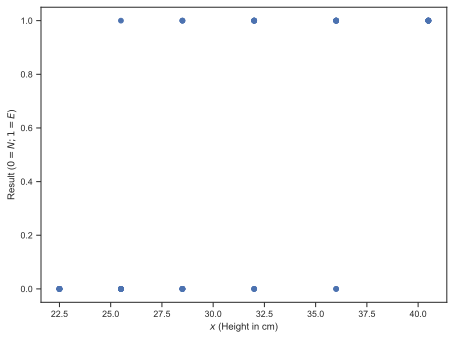

In [31]:
fig, ax = make_full_width_fig()
ax.plot(x, y, 'o')
ax.set_xlabel('$x$ (Height in cm)')
ax.set_ylabel('Result ($0=N; 1=E$)')
save_for_book(fig, 'ch16.fig2')

Let's train a logistic regression model with just a linear feature using scikit-learn:

In [32]:
from sklearn.linear_model import LogisticRegression
X = x[:, None]
model = LogisticRegression().fit(X, y)

Here is how you can get the trained weights of the model:

In [33]:
model.coef_

array([[0.40749103]])

And here is how you can make predictions at some arbitrary heights:

In [34]:
X_predict = np.array([10.0, 20.0, 30.0, 40.0, 50.0])[:, None]
predictions = model.predict_proba(X_predict)
predictions.round(2)

array([[1.  , 0.  ],
       [0.99, 0.01],
       [0.58, 0.42],
       [0.02, 0.98],
       [0.  , 1.  ]])

Note that the model gave us back the probability of each class.
If you wanted, you could ask for the class of maximum probability for each prediction input:

In [35]:
model.predict(X_predict)

array([0, 0, 0, 1, 1])

To visualize the predictions of the model as a function of the height, we can do this:

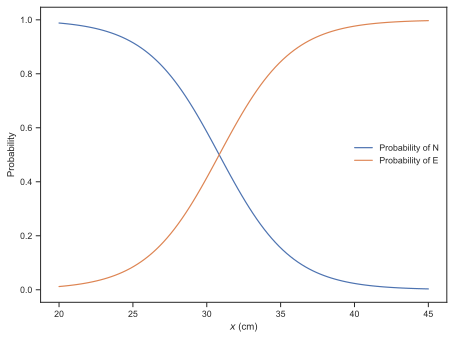

In [36]:
fig, ax = make_full_width_fig()
xx = np.linspace(20.0, 45.0, 100)
XX = xx[:, None]
predictions_xx = model.predict_proba(XX)
ax.plot(xx, predictions_xx[:, 0], label='Probability of N')
ax.plot(xx, predictions_xx[:, 1], label='Probability of E')
ax.set_xlabel('$x$ (cm)')
ax.set_ylabel('Probability')
plt.legend(loc='best')
save_for_book(fig, 'ch16.fig3')

## Questions

+ What is the probability of explosition when the height becomes very small?
+ What is the probability of explosition when the height becomes very large?
+ At what height it is particularly difficult to predict what is going to happen?